In [90]:
import IPython
import requests
import time
import pandas as pd
import ast # to transform str to dic
import praw #for reddit wrapper
import os

In [91]:
# Testing connection

url = 'https://www.reddit.com/hot.json'
header = {'User-agent': 'Bleep blorp bot 0.1'}
res = requests.get(url,headers=header)
the_json = res.json()
print(sorted(the_json.keys()))

the_json['data'].keys()
len(the_json['data']['children'])

['data', 'kind']


25

In [92]:
def get_posts(url,interations,header,sleep):
    posts = []
    after = None
    for i in range(interations):
#         print(i)
        if after==None:
            params = {}
        else:
            params = {'after' : after}
        res = requests.get(url,params=params,headers=header)
        if res.status_code == 200:
            the_json = res.json()
            posts.extend(the_json['data']['children'])
            after = the_json['data']['after']
        else:
            print(res.status_code)
            break
        time.sleep(sleep)
    return posts

def create_cols(dataframe):
    dataframe['subreddit'] = dataframe['data'].map(lambda x: x['subreddit'])
    dataframe['title'] = dataframe['data'].map(lambda x: x['title'])
    dataframe['name'] = dataframe['data'].map(lambda x: x['name'])
    dataframe['selftext'] = dataframe['data'].map(lambda x: x['selftext'])
    dataframe['domain'] = dataframe['data'].map(lambda x: x['domain'])
    return dataframe

In [93]:
# Setting up the Reddit API in python
reddit = praw.Reddit(client_id='mBPz4HF59_0MX5n7TXFGXg',
                     client_secret='L0YrbwjFpyLZs7ia5hTIUyEKuGVrvw',
                     user_agent='User')

# Function for extracting data
def get_posts(subred_name, n, time = 'all'):
    subreddit = reddit.subreddit(subred_name)
    posts_info = [] 
    
    for subm in subreddit.top(limit=n, time_filter=time):
        
        subred_info = []
        subred_info.append(subm.id)  
        subred_info.append(str(subm.author))
        subred_info.append(subm.title)
        subred_info.append(subm.selftext)
        subred_info.append(subm.score)  
        subred_info.append(subm.upvote_ratio)
        subred_info.append(subm.num_comments)
        subred_info.append(subm.subreddit)
        posts_info.append(subred_info)
    
    sorted_info = sorted(posts_info, key=lambda x: x[1], reverse = True)
    posts_df = pd.DataFrame(sorted_info, columns = ['id','author', 'title', 'text', 'score','upvote_ratio' ,'num_comments', 'subreddit'])
    return posts_df

In [94]:
rant_df = get_posts('rant',1000,time="all")
OMC_df = get_posts('offmychest',1000,time="all")
TOMC_df = get_posts('trueoffmychest',1000,time="all")
self_df = get_posts('self',1000,time="all")

In [95]:
OMC_df['subreddit'] = "offmychest"
TOMC_df['subreddit'] = 'TrueOffMyChest'
rant_df['subreddit'] = 'rant'
self_df['subreddit'] = 'self'

full_df = pd.concat([OMC_df, TOMC_df, rant_df, self_df])

In [96]:
full_df

,id,author,title,text,score,upvote_ratio,num_comments,subreddit
0,i1szdi,zoyaa5,The abuse of essential workers needs to stop.,I have dealt with a lot of insanity since this...,8126,0.97,295,offmychest
1,tnk97h,yrthegood1staken,I Miss Her,"My alarm went off at 5:15 this morning, like i...",7525,0.92,575,offmychest
2,x4aag7,yourwrongdoings,My roommate killed my kitten.,Last night my roommate got mad at my kitten af...,7046,0.99,763,offmychest
3,hv24zz,yourmomisexpwaste,Wearing a mask has nothing to do with politics...,Body text\n\n\nAn edit for people who have bee...,24856,0.92,864,offmychest
4,gmlmtr,youngffinance,"I am usually pretty Libertarian, but after thi...",My husband recently broke a bone and had to ha...,9259,0.94,777,offmychest
...,...,...,...,...,...,...,...,...
986,4twyxv,1millionbucks,HEY ADMINS: /r/redditrequest now has a 34 day ...,"Welcome to the modern age, where you have to m...",1619,0.90,109,self
987,230ohk,15963256,A professor just emailed me and now I'm crying,I have the same instructor for 3 classes this ...,1164,0.92,78,self
988,82ax16,1369311007,Resigning my NRA membership.,I will miss the history of firearms in the mag...,957,0.83,180,self
989,vb3oj3,12jonboy12,what I say to my 21-year-old cat every night b...,"I bring him to bed with me and I say:\n ""I'd r...",2243,0.98,182,self


In [97]:
# Load the regular expression library
import re
def cleanUp(df, columnTo, columnFrom):
    # Remove punctuation
    df[columnTo] = df[columnFrom].map(lambda x: re.sub('[,\.!?]', '', x))
    # Convert the titles to lowercase
    df[columnTo] = df[columnFrom].map(lambda x: x.lower())
    return df

<>:5: DeprecationWarning: invalid escape sequence \.
<>:5: DeprecationWarning: invalid escape sequence \.
<>:5: DeprecationWarning: invalid escape sequence \.
/var/folders/4d/8dmpyclj3x10xhz5nx1ynz780000gp/T/ipykernel_12838/2202248827.py:5: DeprecationWarning: invalid escape sequence \.
  df[columnTo] = df[columnFrom].map(lambda x: re.sub('[,\.!?]', '', x))


In [98]:
rant_df = cleanUp(rant_df, 'textClean', 'text')
OMC_df = cleanUp(OMC_df, 'textClean', 'text')
TOMC_df = cleanUp(TOMC_df, 'textClean', 'text')
self_df = cleanUp(self_df, 'textClean', 'text')
full_df = cleanUp(full_df, 'textClean', 'text')

/Users/jacobelder/Documents/GitHub/Reddit-Topic-Model/venv/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/jacobelder/Documents/GitHub/Reddit-Topic-Model/venv/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/Users/jacobelder/Documents/GitHub/Reddit-Topic-Model/venv/lib/python3.7/site-packages/wordcloud/wordcloud.py:508: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/Users/jacobelder/Documents/GitHub/Reddit-Topic-Model/venv/lib/python3.7/site-packages/wordcloud/wordcloud.p

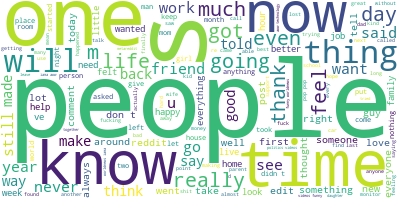

In [99]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(self_df['textClean'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()

In [100]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
data = full_df.textClean.values.tolist()
data_words = list(sent_to_words(data))
# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1045)>


['dealt', 'lot', 'insanity', 'since', 'pandemic', 'started', 'think', 'yesterday', 'took', 'cake', 'year', 'old', 'female', 'work', 'grocery', 'store', 'yesterday', 'man', 'refused', 'wear', 'mask', 'asthma', 'told', 'would', 'ring', 'groceries', 'put', 'without', 'raising', 'voice']


In [101]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [102]:
from pprint import pprint
# number of topics
num_topics = 5
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.010*"people" + 0.008*"like" + 0.008*"get" + 0.007*"know" + 0.006*"would" '
  '+ 0.005*"time" + 0.005*"got" + 0.005*"want" + 0.005*"said" + '
  '0.005*"really"'),
 (1,
  '0.008*"like" + 0.006*"know" + 0.006*"get" + 0.005*"people" + 0.005*"would" '
  '+ 0.005*"never" + 0.005*"one" + 0.005*"got" + 0.004*"much" + 0.004*"years"'),
 (2,
  '0.010*"like" + 0.009*"people" + 0.007*"time" + 0.006*"one" + 0.006*"get" + '
  '0.005*"even" + 0.005*"fucking" + 0.005*"would" + 0.005*"want" + '
  '0.004*"know"'),
 (3,
  '0.058*"fuck" + 0.008*"like" + 0.008*"people" + 0.006*"one" + 0.006*"get" + '
  '0.005*"even" + 0.005*"time" + 0.005*"know" + 0.004*"life" + 0.004*"edit"'),
 (4,
  '0.010*"like" + 0.007*"people" + 0.006*"know" + 0.006*"get" + 0.006*"one" + '
  '0.005*"much" + 0.005*"years" + 0.005*"even" + 0.005*"time" + 0.005*"would"')]


In [112]:
#import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis.gensim
import pyLDAvis
import scipy

# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, n_jobs=4)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

Process LokyProcess-167:
Process LokyProcess-168:
Process LokyProcess-166:
Process LokyProcess-165:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 303, in _bootstrap
    self._parent_name, self._parent_pid, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 303, in _bootstrap
    self._parent_name, self._parent_pid, parent_sentinel)
AttributeError: 'LokyProcess' object has no attribute '_parent_name'
AttributeError: 'LokyProcess' object has no attribute '_parent_name'
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 303, in _bootstrap
    self._parent_name, self._parent_pid, parent_sentinel)
AttributeError: 'LokyProcess' object has no attribute '_parent_name'
Traceback (most recent call last)

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {EXIT(1), EXIT(1), EXIT(1)}

In [ ]:
import gensim
from gensim.utils import simple_preprocess
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = full_df.textClean.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [ ]:
# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
import spacy
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

In [ ]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=100,
                                       per_word_topics=True)

In [ ]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

In [ ]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
import numpy as np
import tqdm
grid = {}
grid['Validation_Set'] = {}
# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)
# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }
# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
                                                  k=k, a=a, b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)
    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=100,
                                           alpha=0.61,
                                           eta=0.91)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared